In [1]:
!python -m pip install "polars[numpy, pandas]"

In [2]:
import numpy as np
import polars as pl

num_rows = 5000
rng = np.random.default_rng(seed=7)

buildings_data = {
      "sqft": rng.exponential(scale=1000, size=num_rows),
      "year": rng.integers(low=1995, high=2023, size=num_rows),
     "building_type": rng.choice(["A", "B", "C"], size=num_rows),
}
buildings = pl.DataFrame(buildings_data)
buildings

sqft,year,building_type
f64,i64,str
707.529256,1996,"""C"""
1025.203348,2020,"""C"""
568.548657,2012,"""A"""
895.109864,2000,"""A"""
206.532754,2011,"""A"""
3383.637351,2018,"""B"""
9.753627,2007,"""A"""
2809.215763,2004,"""B"""
575.332756,2021,"""A"""


In [3]:
buildings.schema

{'sqft': Float64, 'year': Int64, 'building_type': Utf8}

In [4]:
buildings.describe()

describe,sqft,year,building_type
str,f64,f64,str
"""count""",5000.0,5000.0,"""5000"""
"""null_count""",0.0,0.0,"""0"""
"""mean""",994.094456,2008.5258,null
"""std""",1016.641569,8.062353,null
"""min""",1.133256,1995.0,"""A"""
"""max""",9307.793917,2022.0,"""C"""
"""median""",669.370932,2009.0,null
"""25%""",286.807549,2001.0,null
"""75%""",1343.539279,2015.0,null


Within Polars’ three main contexts, there are many different types of expressions, and you can pipe multiple expressions together to run arbitrarily complex queries. To better understand these ideas, take a look at an example of the select context: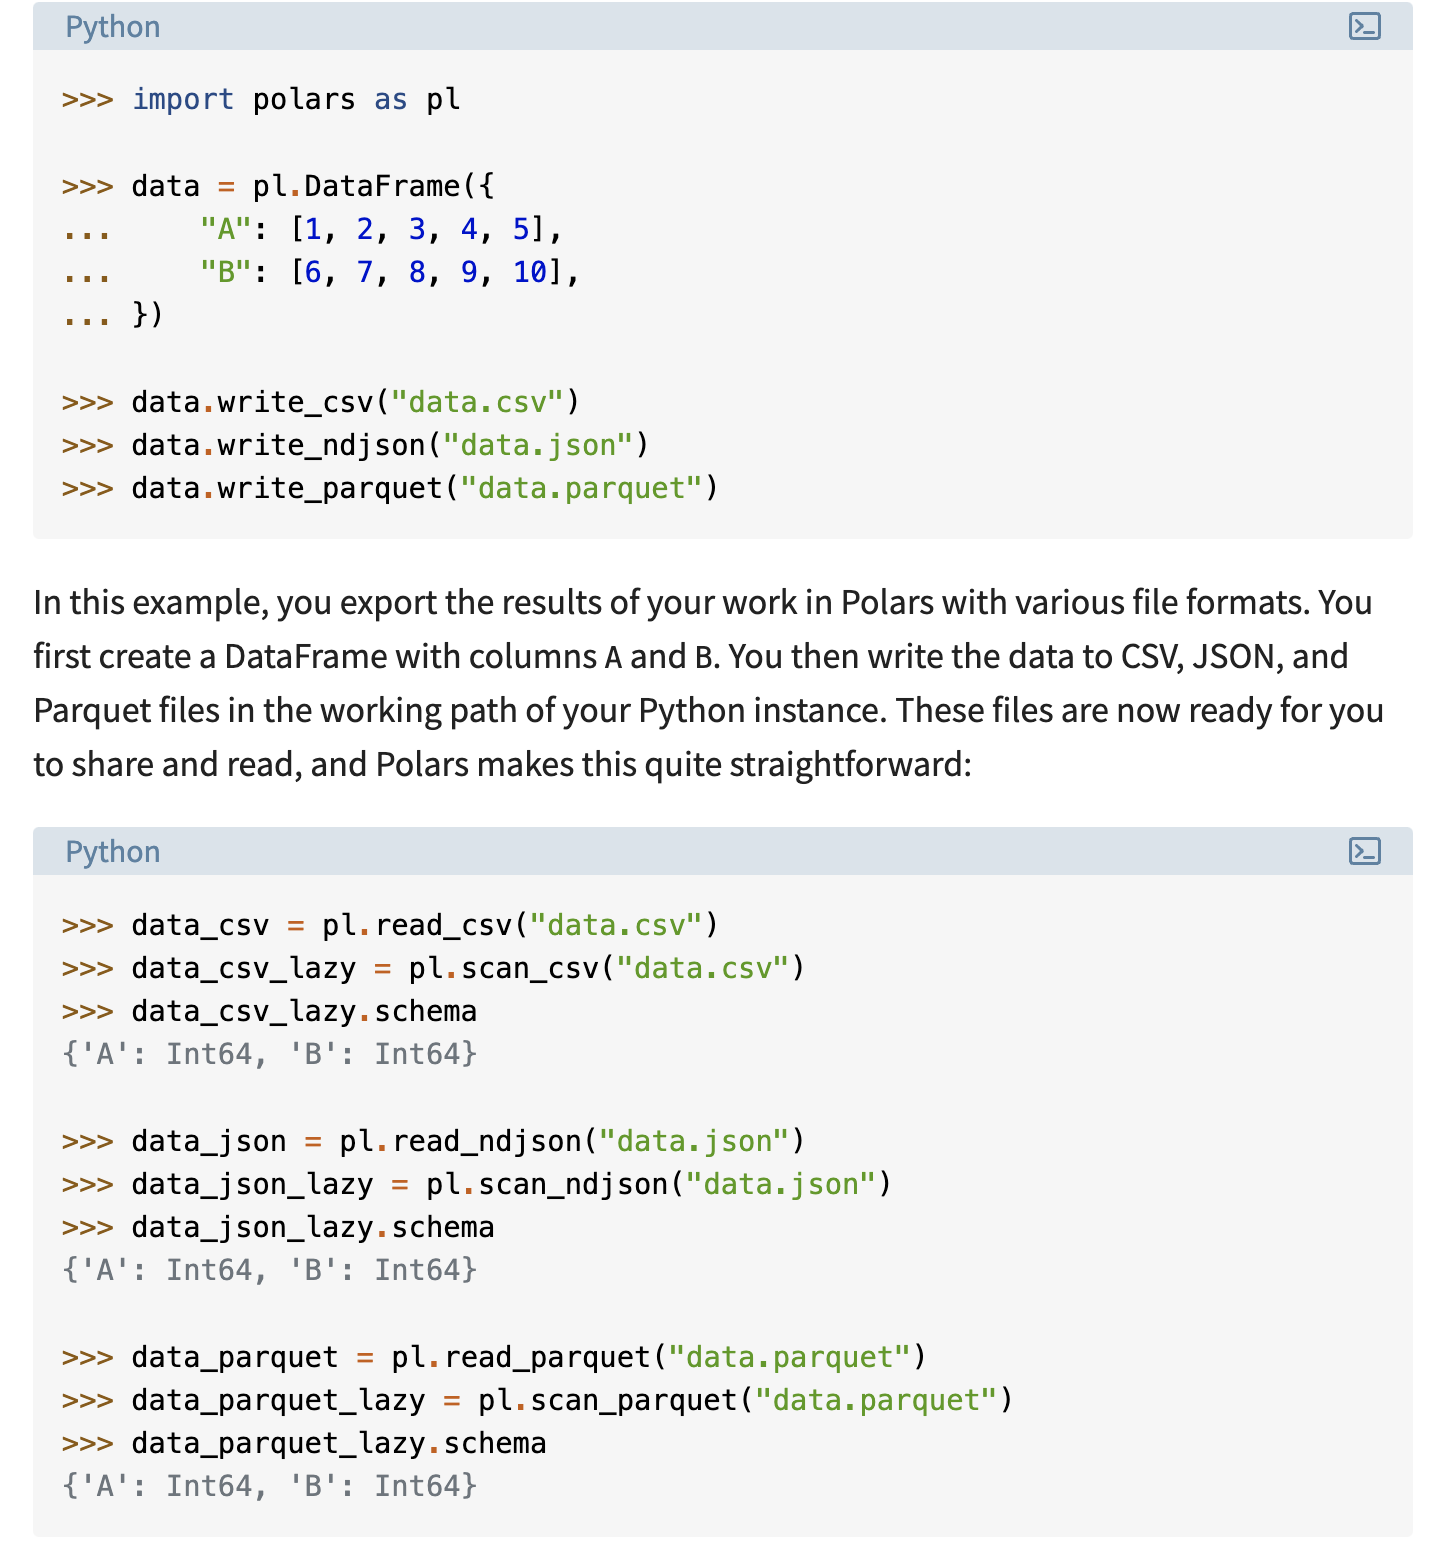

In [5]:
buildings.select("sqft")

sqft
f64
707.529256
1025.203348
568.548657
895.109864
206.532754
3383.637351
9.753627
2809.215763
575.332756


In [6]:
buildings.select(pl.col("sqft").sort() / 1000)

sqft
f64
0.001133
0.001152
0.001429
0.001439
0.001505
0.001597
0.001747
0.00195
0.002005


Another commonly used context in Polars, and data analysis more broadly, is the groupby context, also known as aggregation. This is useful for computing summary statistics within subgroups of your data. In the building data example, suppose you want to know the average square footage, median building year, and number of buildings for each building type. The following query accomplishes this task:

In [7]:
buildings.groupby("building_type").agg(
...      [
...          pl.mean("sqft").alias("mean_sqft"),
...          pl.median("year").alias("median_year"),
...          pl.count(),
...      ]
...  )


building_type,mean_sqft,median_year,count
str,f64,f64,u32
"""B""",992.754444,2009.0,1655
"""C""",999.854722,2009.0,1692
"""A""",989.539918,2009.0,1653


## The Lazy API
Polars’ lazy API is one of the most powerful features of the library. With the lazy API, you can specify a sequence of operations without immediately running them. Instead, these operations are saved as a computational graph and only run when necessary. This allows Polars to optimize queries before execution, catch schema errors before the data is processed, and perform memory-efficient queries on datasets that don’t fit into memory.

In [8]:
buildings = {
      "sqft": rng.exponential(scale=1000, size=num_rows),
      "price": rng.exponential(scale=100_000, size=num_rows),
     "year": rng.integers(low=1995, high=2023, size=num_rows),
      "building_type": rng.choice(["A", "B", "C"], size=num_rows),
  }
buildings_lazy = pl.LazyFrame(buildings)

buildings_lazy


In [9]:
lazy_query = (
...     buildings_lazy
...     .with_columns(
...         (pl.col("price") / pl.col("sqft")).alias("price_per_sqft")
...     )
...     .filter(pl.col("price_per_sqft") > 100)
...     .filter(pl.col("year") < 2010)
...  )
lazy_query


In [10]:
print(lazy_query.explain())

FILTER [(col("price_per_sqft")) > (100.0)] FROM WITH_COLUMNS:
 [[(col("price")) / (col("sqft"))].alias("price_per_sqft")]
  DF ["sqft", "price", "year", "building_type"]; PROJECT */4 COLUMNS; SELECTION: "[(col(\"year\")) < (2010)]"


With an understanding of what your lazy query is set to do, you’re ready to actually execute it. To do this, you call .collect() on your lazy query to evaluate it according to the query plan. Here’s what this looks like in action:

In [11]:
(
...     lazy_query
...     .collect()
...     .select(pl.col(["price_per_sqft", "year"]))
...     .describe()
... )

describe,price_per_sqft,year
str,f64,f64
"""count""",1338.0,1338.0
"""null_count""",0.0,0.0
"""mean""",1197.977747,2001.893124
"""std""",5821.706266,4.32589
"""min""",100.357816,1995.0
"""max""",154895.785598,2009.0
"""median""",298.700086,2002.0
"""25%""",174.913631,1998.0
"""75%""",703.415704,2006.0


## Scanning Data Efficiently with LazyFrames

In practical scenarios, it's common to store data externally in static files or databases before processing it in Python. The lazy API provides a significant advantage by enabling the processing of large datasets stored in files without the need to load the entire dataset into memory.

Traditionally, when dealing with files like CSVs, the approach involves reading all the data into memory before analysis. However, Polars' lazy API changes this paradigm by allowing the processing of only necessary data, minimizing both memory usage and computation time.

In the upcoming example, we'll explore electric vehicle population data from Data.gov, which contains information about electric and hybrid vehicles registered with the Washington State Department of Licensing. Each row represents a car, with columns holding specific car-related details.

You can obtain this data manually from the website or use the provided function for programmatic downloading. Ensure that you have the 'requests' library installed in your environment before attempting this example.

In [12]:
%%writefile  downloads.py

import requests
import pathlib

def download_file(file_url: str, local_file_path: pathlib.Path) -> None:
    """Download a file and save it with the specified file name."""
    response = requests.get(file_url)
    if response:
        local_file_path.write_bytes(response.content)
        print(f"File successfully downloaded and stored at: {local_file_path}")
    else:
        raise requests.exceptions.RequestException(
            f"Failed to download the file. Status code: {response.status_code}"
        )

Writing downloads.py


In [13]:
import pathlib
from downloads import download_file

url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"
local_file_path = pathlib.Path("electric_cars.csv")
download_file(url, local_file_path)

File successfully downloaded and stored at: electric_cars.csv


In [14]:
lazy_car_data = pl.scan_csv(local_file_path)
lazy_car_data

lazy_car_data.schema

{'VIN (1-10)': Utf8,
 'County': Utf8,
 'City': Utf8,
 'State': Utf8,
 'Postal Code': Int64,
 'Model Year': Int64,
 'Make': Utf8,
 'Model': Utf8,
 'Electric Vehicle Type': Utf8,
 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': Utf8,
 'Electric Range': Int64,
 'Base MSRP': Int64,
 'Legislative District': Int64,
 'DOL Vehicle ID': Int64,
 'Vehicle Location': Utf8,
 'Electric Utility': Utf8,
 '2020 Census Tract': Int64}

In [15]:
lazy_car_query = (
...     lazy_car_data
...     .filter((pl.col("Model Year") >= 2018))
...     .filter(
...         pl.col("Electric Vehicle Type") == "Battery Electric Vehicle (BEV)"
...     )
...     .groupby(["State", "Make"])
...     .agg(
...         pl.mean("Electric Range").alias("Average Electric Range"),
...         pl.min("Model Year").alias("Oldest Model Year"),
...         pl.count().alias("Number of Cars"),
...     )
...     .filter(pl.col("Average Electric Range") > 0)
...     .filter(pl.col("Number of Cars") > 5)
...     .sort(pl.col("Number of Cars"), descending=True)
... )

lazy_car_query.collect()

State,Make,Average Electric Range,Oldest Model Year,Number of Cars
str,str,f64,i64,u32
"""WA""","""TESLA""",73.107262,2018,67461
"""WA""","""CHEVROLET""",102.115445,2018,6358
"""WA""","""NISSAN""",81.207053,2018,6153
"""WA""","""FORD""",0.136986,2018,4380
"""WA""","""KIA""",51.634242,2018,4071
"""WA""","""VOLKSWAGEN""",17.430279,2018,4016
"""WA""","""HYUNDAI""",18.63851,2018,3303
"""WA""","""AUDI""",76.88518,2019,1977
"""WA""","""BMW""",14.678992,2018,1785
